In [12]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchshow as ts
import torchmetrics
import matplotlib.pyplot as plt

In [13]:
# Importere dataset, kun træning indtil videre.
training_images = MNIST(root='data', transform=ToTensor(), train=True)
training_dataloader = DataLoader(training_images, batch_size=1000)
testing_images = MNIST(root='data', transform=ToTensor(), train=False)
testing_dataloader = DataLoader(testing_images, batch_size=1000)

In [14]:
# Laver det Neurale Netværk, og opstiller et accuracy objekt til at måle hvor god modellen er.
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
net = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=3), #første parameter 1 er antal kanaler, her 1 fordi vi arbejder med gråtoner; 12 er antal ouputkanaler, altså antal filtre; 3 er størrelsen på det udsnit af billedet vi tager, som så bliver 3x3 matrice af pixels.
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), #vælger den maksimale værdi i et udsnit af størrelsen 2x2, således dimensionerne af dataene reduceres fra 28x28 til 14x14
    nn.Conv2d(10, 10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), #vælger den maksimale værdi i et udsnit af størrelsen 2x2, således dimensionerne af dataene reduceres fra 14x14 til 7x7
    nn.Flatten(),
    nn.Linear(250,10), # input er nu 5 x 5 x 10
)
# Bruger crossentropy til at udregne losset, og indstiller optimizeren.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, maximize=False)

In [15]:
# Loop'er over 10 epoker, og udregner loss'et og accuracy for hvert.
def training_loop(training_dataloader, optimizer, loss_fn):
    total_loss = 0
    accuracy.reset()
    size = len(training_dataloader)
    for images,labels in training_dataloader:
        optimizer.zero_grad()
        output = net(images)
        loss = loss_fn(output, labels)
        total_loss += loss
        loss.backward()
        optimizer.step()
        accuracy.update(output, labels)
    avg_loss = total_loss / size
    print(f"Avg Training Accuracy: {accuracy.compute() * 100:.2f}%")
    print(f"Avg Training Loss: {avg_loss}")

def testing_loop(testing_dataloader, loss_fn):
    total_loss = 0
    accuracy.reset()
    size = len(testing_dataloader)
    with torch.no_grad():
        for images,labels in testing_dataloader:
            output = net(images)
            loss = loss_fn(output, labels)
            total_loss += loss
            accuracy.update(output,labels)
    avg_loss = total_loss / size
    print(f"Avg Testing Accuracy: {accuracy.compute() * 100 :.2f}%")
    print(f"Avg Testing Loss: {avg_loss}")

In [16]:
for i in range(20):
    print(f"Epoch: {i}")
    testing_loop(testing_dataloader, loss_fn)
    training_loop(training_dataloader, optimizer, loss_fn)
    print("------------------")

Epoch: 0
Avg Testing Accuracy: 9.02%
Avg Testing Loss: 2.300119400024414
Avg Training Accuracy: 85.55%
Avg Training Loss: 0.5155499577522278
------------------
Epoch: 1
Avg Testing Accuracy: 95.85%
Avg Testing Loss: 0.14929404854774475
Avg Training Accuracy: 96.24%
Avg Training Loss: 0.12710736691951752
------------------
Epoch: 2
Avg Testing Accuracy: 97.29%
Avg Testing Loss: 0.09350116550922394
Avg Training Accuracy: 97.34%
Avg Training Loss: 0.08821598440408707
------------------
Epoch: 3
Avg Testing Accuracy: 97.65%
Avg Testing Loss: 0.0727459192276001
Avg Training Accuracy: 97.84%
Avg Training Loss: 0.07086966186761856
------------------
Epoch: 4
Avg Testing Accuracy: 97.85%
Avg Testing Loss: 0.07019895315170288
Avg Training Accuracy: 98.18%
Avg Training Loss: 0.06120595708489418
------------------
Epoch: 5
Avg Testing Accuracy: 97.99%
Avg Testing Loss: 0.06644191592931747
Avg Training Accuracy: 98.34%
Avg Training Loss: 0.05475080758333206
------------------
Epoch: 6
Avg Testing 

Model output:
tensor([[ -4.1196, -20.9900,  -4.3859,  -4.8772,  -7.1593,  17.0437,  10.5028,
         -13.6950,   2.6679,  -1.0215]], grad_fn=<AddmmBackward0>)
Efter softmax:
tensor([[6.4309e-10, 3.0306e-17, 4.9273e-10, 3.0149e-10, 3.0772e-11, 9.9856e-01,
         1.4411e-03, 4.4640e-14, 5.7022e-07, 1.4249e-08]],
       grad_fn=<SoftmaxBackward0>)
Modul bud: 5
Korrekt: 5


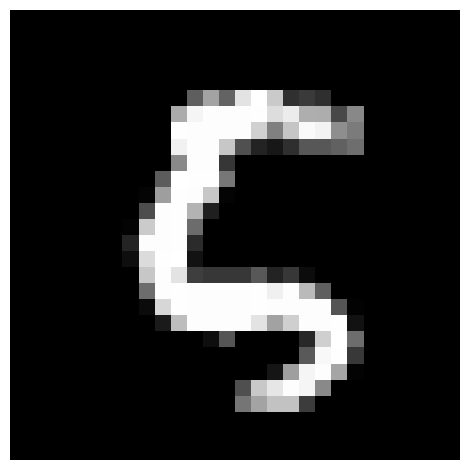

In [19]:
# Afprøver modellen på et givent index af billederne.
img_idx = 2000
pred = net(training_images[img_idx][0].unsqueeze(0)) 
print("Model output:")
print(pred)
sm = nn.Softmax(dim=1)
print("Efter softmax:")
print(sm(pred))
print(f"Modul bud: {pred.argmax()}")
print(f"Korrekt: {training_images[img_idx][1]}")
ts.show(training_images[img_idx][0])

In [18]:
# Pytorch Documentation og Mikkels ting
def preprocess(image):
    gs = torchvision.transforms.Grayscale(num_output_channels=1)
    image = image[0:3]
    image = torchvision.transforms.functional.resize(image, [28, 28], antialias=True)
    image = gs(image)
    image = image.float()/255
    image = torchvision.transforms.functional.invert(image)
    image = torchvision.transforms.functional.adjust_contrast(image, 13)
    tresh = torch.nn.Threshold(0.28, 0.0)
    image = tresh(image)
    return image